In [ ]:
%matplotlib inline


# Neural network regression

In this example, we will train a deep network to fit a simple 1D function, and evaluate the impact of the architecture and optimizer.

## Defining a neural network
First, we would like to highlight the limitations of a linear model given
our dataset. If we don't use any non-linear functions, the neural network can only learn a linear function. We start by defining the neural network function using the torch.nn.Module



In [ ]:
import torch.nn as nn
import torch
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.RandomState(0)
data = np.linspace(-3, 3, num=100).reshape(-1, 1)

feature_regime = False
non_linearity = 'relu'
n = 1024 #2048
bias = True
N = 20 # training datapoints
noise_std = .2 # standard deviation of the noise in the train data

class Sinusoid(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
      return torch.sin(2*3.14*x)

In [ ]:
def StandardNet(n, depth, non_linearity, bias):
  net = nn.Sequential(nn.Linear(1,n, bias=bias)) 
  for s in range(depth-2):  
    if non_linearity == 'relu':
      net.append(nn.ReLU())
    elif non_linearity == 'sin':
      net.append(Sinusoid())
    else:
      net.append(nn.Sigmoid())    
    net.append(nn.Linear(n, n, bias=bias))
  if non_linearity == 'relu':
    net.append(nn.ReLU())
  elif non_linearity == 'sin':
    net.append(Sinusoid())
  else:
    net.append(nn.Sigmoid())    
  net.append(nn.Linear(n, 1, bias=bias))
  return net


class FeatureNet(nn.Module):
    def __init__(self, n, non_linearity='relu', bias=True):
        super().__init__()
        self.lin1 = nn.Linear(1, n, bias=bias)
        self.lin2 = nn.Linear(n, 1, bias=bias)
        if non_linearity == 'relu':
          nonlin = nn.ReLU()
        elif non_linearity == 'sin':
          nonlin = Sinusoid()
        else:
          nonlin = nn.Sigmoid() 
        self.nonlin = nonlin
        torch.nn.init.normal_(self.lin1.weight)
        torch.nn.init.normal_(self.lin2.weight)

    def forward(self, x):
      out = self.nonlin(self.lin1(x))
      return self.lin2(out)/n


# Choose neural network

In [ ]:
from copy import deepcopy
if feature_regime:
  net = FeatureNet(n, non_linearity, bias)
  lr = 1
else:
  depth = 2 # minimum 2
  net = StandardNet(n, depth, non_linearity, bias)
  lr = 1/n

net0 = deepcopy(net) # copy for later

# Gaussian Process at Initialisation


Text(0, 0.5, 'network output')

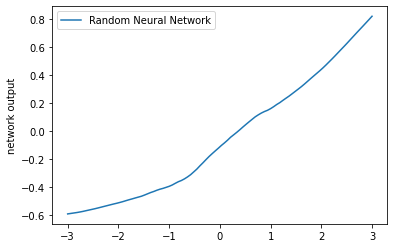

In [ ]:
plt.plot(data, net(torch.Tensor(data)).detach().numpy(), label="Random Neural Network")
plt.legend()
plt.ylabel("network output")

## Generating a dataset

We create a synthetic dataset. The true generative process will take a 1-D
vector and compute its sine. 


In [ ]:
target = np.sin(data).ravel()

Now, we can imagine a scenario where we get observations from this true
process. However, we will add some challenges:

- the measurements will be noisy;
- only samples from the beginning of the signal will be available.



# Dataloader
We first need to define a Torch dataset that encapsules our generative process. We can create a our custom dataset by inheriting from the class `torch.utils.data.dataset.Dataset`

In [ ]:
import torch
from torch.utils.data.dataset import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, target, n, noise_std=.05):
        training_sample_indices = np.arange(0, len(data), int(len(data)/n)) # rng.choice(np.arange(0, len(data)), size=n, replace=False)
        self.training_data = torch.Tensor(data[training_sample_indices])
        self.training_noisy_target = torch.Tensor(target[training_sample_indices] + noise_std * rng.randn(len(training_sample_indices)))
    def __getitem__(self, index):
        return (self.training_data[index], self.training_noisy_target[index])

    def __len__(self):
        return len(self.training_data)

Let's plot the true signal and the noisy measurements available for training.



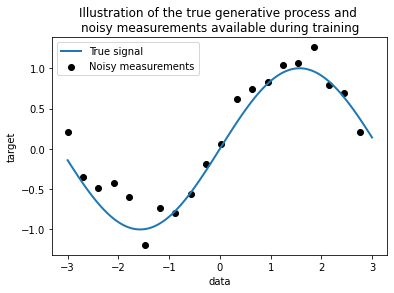

In [ ]:
import matplotlib.pyplot as plt

dataset = CustomDataset(data, target, n=N, noise_std=noise_std)
plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    dataset.training_data,
    dataset.training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Illustration of the true generative process and \n"
    "noisy measurements available during training"
)

Training the network requires defining a dataloader `torch.utils.data.DataLoader`, an optimizer `torch.optim.SGD` and performing a loop over mini-batches of training data.
We'll do so and plot the training loss as a function of the epochs in order to make sure that we are actually minising the empirical risk!


Text(0, 0.5, 'training loss')

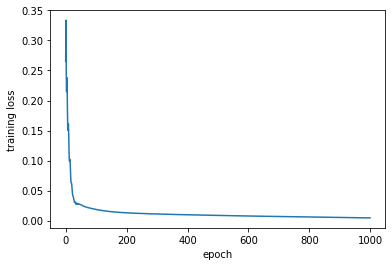

In [ ]:
criterion = torch.nn.MSELoss()
epochs = 1000
dataloader = torch.utils.data.DataLoader(dataset, batch_size=N, shuffle=True)

optimizer = torch.optim.Adam(net.parameters(), lr=lr)

losses = []
for ep in range(epochs):
    err = []
    for i, (x,y) in enumerate(dataloader):
        out = net(x).squeeze(1)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        err.append(loss.item())
    
    losses.append(np.mean(err))
  
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("training loss")

Let's now inspect the learned function

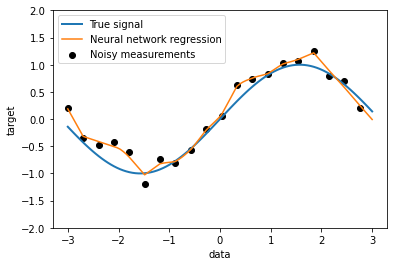

In [ ]:
plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    dataset.training_data,
    dataset.training_noisy_target,
    color="black",
    label="Noisy measurements",
)
with torch.no_grad():
  plt.plot(data, net(torch.Tensor(data)), label="Neural network regression")
  plt.legend()
  plt.xlabel("data")
  plt.ylabel("target")
  plt.ylim(-2,2)

# Linearized Network
Define the linear version

Text(0, 0.5, 'network output')

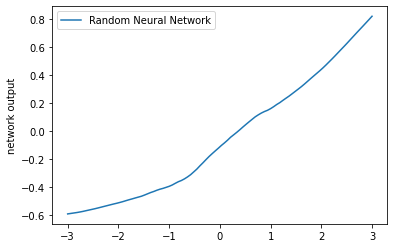

In [ ]:
class LinearisedNet(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.netd = deepcopy(net)

    def forward(self, x, net0):
      N = x.shape[0]
      out = torch.zeros_like(x)

      f = net0(x)

      for i in range(N):
        gradients = torch.autograd.grad(f[i], net0.parameters(), retain_graph=True)
        r = 0
        for g, p,t in zip(gradients, net0.parameters(), self.netd.parameters()):
            r += (g*(t-p)).flatten().sum()

        out[i] = r
      
      return out + f


linear_net = LinearisedNet(net0)


plt.plot(data, linear_net(torch.Tensor(data),net0).detach().numpy(), label="Random Neural Network")
plt.legend()
plt.ylabel("network output")

Train the linearized net

Text(0, 0.5, 'training loss')

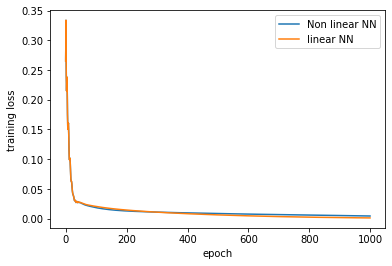

In [ ]:
optimizer = torch.optim.Adam(linear_net.parameters(), lr=lr)

losses2 = []
for ep in range(epochs):
    err = []
    for i, (x,y) in enumerate(dataloader):
        out = linear_net(x, net0).squeeze(1)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        err.append(loss.item())
    
    losses2.append(np.mean(err))
  
plt.plot(losses, label='Non linear NN')
plt.plot(losses2, label='linear NN')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("training loss")

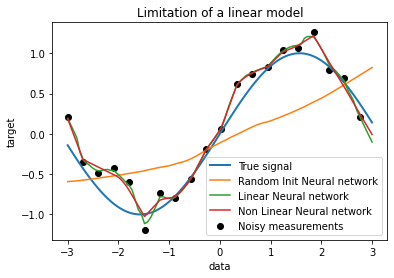

In [ ]:
plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    dataset.training_data,
    dataset.training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(data, net0(torch.Tensor(data)).detach().numpy(), label="Random Init Neural network")
plt.plot(data, linear_net(torch.Tensor(data), net0).detach().numpy(), label="Linear Neural network")
plt.plot(data, net(torch.Tensor(data)).detach().numpy(), label="Non Linear Neural network")
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Limitation of a linear model")